In [1]:
# connecting to google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# installing dependencies
! pip install transformers datasets --quiet
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 82.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 85.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 16.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━

In [3]:
# importing required libraries
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [5]:
# reading the training dataset
train_df = pd.read_csv('/content/drive/MyDrive/NLP_Mini_Project/Data_Augmentation_Techniques/Back_Transilation/Augmented_Train.csv')
train_df.head()

,headline,label
0,सचिन तेंडुलकरने बाळासाहेबांच्या आठवणींना दिला ...,2
1,Sachin Tendulkar brought light to the memories...,2
2,सचिन तेंडुलकरने बाळासाहेबांच्या आठवणींना उजाळा...,2
3,बहुजन वंचित आघाडीची पहिली यादी जाहीर प्रकाश आं...,2
4,बहुजन वंचित आघाडीची पहिली यादी जाहीर प्रकाश आं...,2


In [6]:
# reading the testing dataset
test_df = pd.read_csv('/content/drive/MyDrive/NLP_Mini_Project/Data_Augmentation_Techniques/Back_Transilation/Test_clean.csv')
test_df.head()

,headline,label
0,लग्नाच्या दुसऱ्याच दिवशी नदीत बुडून नवरदेवाचा ...,2
1,"आराखडा रद्द, शिवसेनेकडून निर्णयाचं स्वागत",2
2,"ट्रकची बसला जोरदार धडक, 5 जणांचा मृत्यू",2
3,आॅस्ट्रेलियन ओपनमध्ये सानिया पराभूत,1
4,भूपेन हजारिका यांचा जीवनप्रवास,0


In [7]:
# splitting the data into training and validation set
num_of_rows = int(len(train_df) * 0.8)
values = train_df.values
np.random.shuffle(values)
train_df = values[:num_of_rows] 
validation_df = values[num_of_rows:]
train_df = pd.DataFrame(train_df, columns = ['headline', 'label'])
validation_df = pd.DataFrame(validation_df, columns = ['headline', 'label'])
train_df.rename(columns = {'headline': 'text'}, inplace = True)
validation_df.rename(columns = {'headline': 'text'}, inplace = True)
test_df.rename(columns = {'headline': 'text'}, inplace = True)
print(train_df.shape, validation_df.shape, test_df.shape)

(12760, 2) (3191, 2) (1010, 2)


In [8]:
# loading dataset using Dataset Loader
train_df_hg = Dataset(pa.Table.from_pandas(train_df))
validation_df_hg = Dataset(pa.Table.from_pandas(validation_df))
test_df_hg = Dataset(pa.Table.from_pandas(test_df))

In [16]:
# tokenizing datasets using Kannada BERT
checkpoint = 'bert-base-multilingual-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example['text'] ,truncation = True)

train_df_tokenised = train_df_hg.map(tokenize_function, batched = True)
validation_df_tokenised = validation_df_hg.map(tokenize_function, batched = True)
test_df_tokenised = test_df_hg.map(tokenize_function, batched = True)
data_collator = DataCollatorWithPadding(tokenizer = tokenizer, return_tensors = 'tf')

Map:   0%|          | 0/12760 [00:00<?, ? examples/s]

Map:   0%|          | 0/3191 [00:00<?, ? examples/s]

Map:   0%|          | 0/1010 [00:00<?, ? examples/s]

In [17]:
# converting datasets to tensorflow datasets
tf_train_dataset = train_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = True,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_validation_dataset = validation_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

tf_test_dataset = test_df_tokenised.to_tf_dataset(
    columns = ['attention_mask', 'input_ids', 'token_type_ids'],
    label_cols = ['label'],
    shuffle = False,
    collate_fn = data_collator,
    batch_size = 8,
)

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [18]:
# loading the model for classification
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, from_pt = True, num_labels = 3)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
# defining hyper parameters
num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(initial_learning_rate = 5e-5, end_learning_rate = 0.0, decay_steps = num_train_steps)
opt = Adam(learning_rate = lr_scheduler)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [20]:
# compiling the model
model.compile(optimizer = opt, loss = loss, metrics = ['accuracy'])

In [21]:
# adding early stopping to prevent overfitting
early_stopping_callback = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 2, patience = 3 )

In [ ]:
# training the model
history = model.fit(tf_train_dataset, callbacks = early_stopping_callback, validation_data = tf_validation_dataset, epochs = 100, verbose = 2, batch_size = 128)

Epoch 1/100
1595/1595 - 253s - loss: 0.4808 - accuracy: 0.8221 - val_loss: 0.3204 - val_accuracy: 0.8859 - 253s/epoch - 158ms/step
Epoch 2/100
1595/1595 - 185s - loss: 0.2394 - accuracy: 0.9254 - val_loss: 0.1963 - val_accuracy: 0.9383 - 185s/epoch - 116ms/step
Epoch 3/100
1595/1595 - 179s - loss: 0.2979 - accuracy: 0.8979 - val_loss: 0.1874 - val_accuracy: 0.9445 - 179s/epoch - 112ms/step
Epoch 4/100
1595/1595 - 194s - loss: 0.1209 - accuracy: 0.9642 - val_loss: 0.1616 - val_accuracy: 0.9514 - 194s/epoch - 122ms/step
Epoch 5/100
1595/1595 - 180s - loss: 0.0760 - accuracy: 0.9797 - val_loss: 0.1312 - val_accuracy: 0.9649 - 180s/epoch - 113ms/step
Epoch 6/100
1595/1595 - 186s - loss: 0.0567 - accuracy: 0.9850 - val_loss: 0.1194 - val_accuracy: 0.9665 - 186s/epoch - 117ms/step
Epoch 7/100
1595/1595 - 185s - loss: 0.0401 - accuracy: 0.9895 - val_loss: 0.0938 - val_accuracy: 0.9762 - 185s/epoch - 116ms/step
Epoch 8/100
1595/1595 - 179s - loss: 0.0217 - accuracy: 0.9946 - val_loss: 0.0994 -

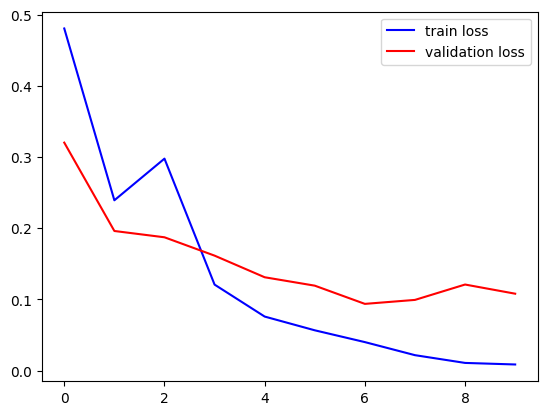

In [ ]:
# plotting the loss curve
plt.plot(history.history['loss'], c = 'b', label = 'train loss')
plt.plot(history.history['val_loss'], c = 'r', label = 'validation loss')
plt.legend()
plt.show()

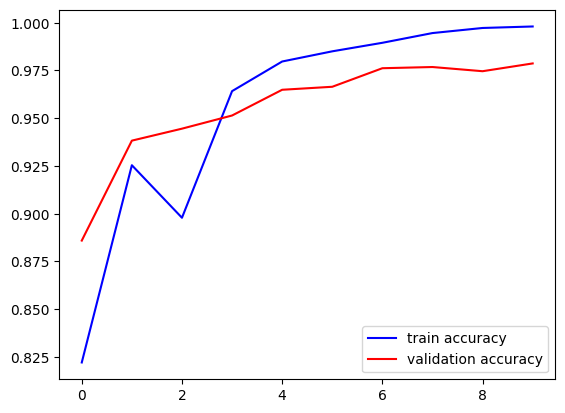

In [ ]:
# plotting the accuracy curve
plt.plot(history.history['accuracy'], c = 'b', label = 'train accuracy')
plt.plot(history.history['val_accuracy'] , c = 'r', label = 'validation accuracy')
plt.legend(loc = 'lower right')
plt.show()

In [ ]:
# using the trained model to predict the test labels
preds = model.predict(tf_test_dataset)['logits']
class_preds = np.argmax(preds, axis = 1)
print(preds.shape, class_preds.shape)

127/127 [==============================] - 10s 50ms/step
(1010, 3) (1010,)


In [ ]:
y_test = test_df.label.values
y_pred = class_preds

In [ ]:
# evaluating the predictions
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: %.2f%%' % (accuracy * 100.0))

Accuracy: 90.99%


In [ ]:
# printing the classification results
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       276
           1       0.90      0.77      0.83       106
           2       0.92      0.96      0.94       628

    accuracy                           0.91      1010
   macro avg       0.90      0.86      0.88      1010
weighted avg       0.91      0.91      0.91      1010



In [ ]:
# printing the confusion matrix for the classification
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[232   6  38]
 [ 12  82  12]
 [ 20   3 605]]
